# TP3

In [1]:
import src.data as data

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### **Question 1**
Displaying the distribution of genres as a bar plot.

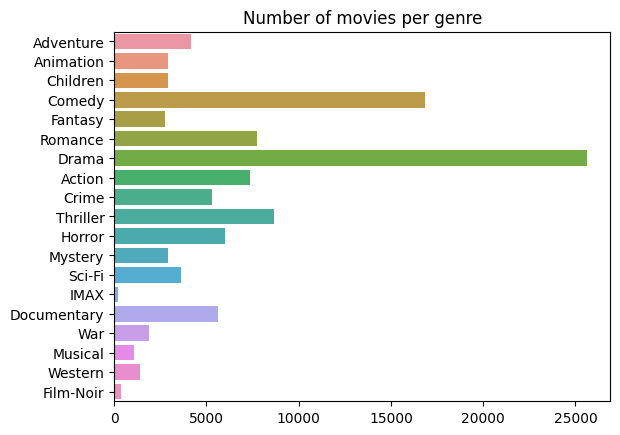

In [2]:
# Loading data
movies = data.load_movies()

# Counting occurences of each genre
genre_count = {}
for mov in movies.values:
    for genre in mov[2]:
        if genre in genre_count:
            genre_count[genre] += 1
        else:
            genre_count[genre] = 1

# Ignoring '(no genres listed)' genre
genre_count.pop('(no genres listed)')

# Plotting
p = sns.barplot(y=list(genre_count.keys()), x=list(genre_count.values()), orient='h')
p.set_title('Number of movies per genre')
plt.show()

### **Question 2**
Creating two new data files `movies1.csv` and `ratings1.csv` containing only the movies that have a genre listed and the ratings for those movies.

In [2]:
# Creating movies1.csv
movies_with_genre_id = []
# Reading movies.csv
with open('data/movies.csv', 'r', encoding='utf-8') as f:
    lines = f.readlines()
with open('data/movies1.csv', 'w', encoding='utf-8') as f:
    for line in lines:
        if 'no genres listed' not in line:
            # Writing line to movies1.csv
            f.write(line)
            # Getting movie id
            movies_with_genre_id.append(line.split(',')[0])

In [3]:
# Creating ratings1.csv (can take several minutes AND timeout because of notebooks usual weirsness)
modified_ratings = {'5.5': '5', '5.0': '5', '4.5': '4', '4.0': '4', '3.5': '3', '3.0': '3', '2.5': '2', '2.0': '2', '1.5': '1', '1.0': '1', '0.5': '1', '0.0': '0'}
# Reading ratings.csv
with open('data/ratings.csv', 'r', encoding='utf-8') as f:
    lines = f.readlines()
with open('data/ratings1.csv', 'w', encoding='utf-8') as f:
    f.write(lines[0])
    for line in lines[1:]:
        s = line.split(',')
        if s[1] in movies_with_genre_id:
            # Modifying the rating
            s[2] = modified_ratings[s[2]]
            # Writing line to ratings1.csv
            f.write(','.join(s))

### **Question 3**
Building a binary matrix `movie_genre_matrix` where :

`movie_genre_matrix[i,j] = 1` if the movie `i` is of genre `j` and `movie_genre_matrix[i,j] = 0` otherwise.

In [3]:
movies = data.load_movies_with_genre()

unique_genres = data.unique_genres()

# Maps movie id to index in movie_genre_matrix
movies_map = {movie_id: i for i, movie_id in enumerate(movies['movieId'])}

movie_genre_matrix = np.zeros((len(movies_map), len(unique_genres)))

for i, movie_genres in enumerate(movies['genres']):
    for j, genre in enumerate(unique_genres):
        if genre in movie_genres:
            movie_genre_matrix[i, j] = 1

### **Question 4**
Computing the profile vector of each user `u`, where the `k`-th coordinate of the profile vector of `u` is the sum of the ratings given by `u` to the movies of genre `k`.

The profiles are stored in a matrix `users_profiles` where the `k`-th row is the profile vector of the user `k`.

In [4]:
# Can take several minutes aswell

ratings = data.load_ratings_with_genre()
users = data.unique_userIds(ratings)

# Maps user id to index in users_profiles
users_map = {user: i for i, user in enumerate(users)}

users_profiles = np.zeros((len(users), len(unique_genres)))

for _, rating in ratings.iterrows():
    users_profiles[users_map[rating['userId']]] += rating['rating'] * movie_genre_matrix[movies_map[rating['movieId']]]

### **Question 5**

We start by normalizing the data between 0 and 1. It allow the clustering algorithm to run **thousands** of times faster.

In [5]:
max_ = 0
for u in range(len(users_profiles)):
    if np.max(users_profiles[u]) > max_:
        max_ = np.max(users_profiles[u])
users_profiles /= max_

Then we use the `spectral_clustering` function from `sklearn` to cluster the data and the `silhouette_score` function to compute the silhouette score of each clustering that we plot. We run the clustering algorithm for `k` between 2 and 5 to find the best `k`.

K = 2
	Cluster 0: 9858 users
	Cluster 1: 656 users
	Silhouette score for 2 clusters: 0.7784325933612091

K = 3
	Cluster 0: 1092 users
	Cluster 1: 9420 users
	Cluster 2: 2 users
	Silhouette score for 3 clusters: 0.7349443268928529

K = 4
	Cluster 0: 1328 users
	Cluster 1: 11 users
	Cluster 2: 2 users
	Cluster 3: 9173 users
	Silhouette score for 4 clusters: 0.71308793309024

K = 5
	Cluster 0: 9051 users
	Cluster 1: 2 users
	Cluster 2: 691 users
	Cluster 3: 759 users
	Cluster 4: 11 users
	Silhouette score for 5 clusters: 0.6723605501712672



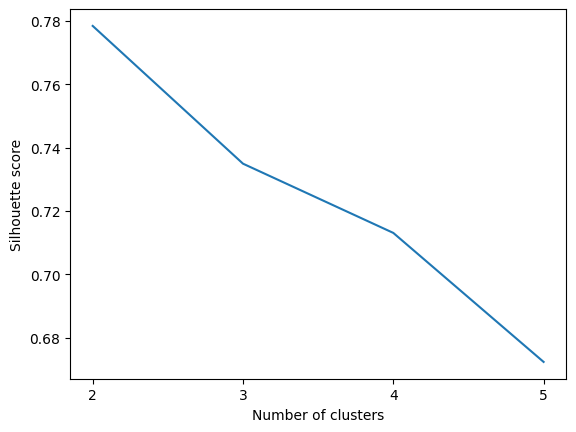

In [6]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score


silhouette_scores = []
labels = []

for k in range(2, 6):
    clustering = SpectralClustering(n_clusters=k, assign_labels="kmeans", n_jobs=-1).fit(users_profiles)
    # clustering = SpectralClustering(n_clusters=k, assign_labels="kmeans", n_jobs=-1, eigen_solver='lobpcg').fit(users_profiles)
    # clustering = SpectralClustering(n_clusters=k, assign_labels="kmeans", n_jobs=-1, eigen_solver='amg').fit(users_profiles)
    print(f'K = {k}')
    for i in range(k):
        print(f'\tCluster {i}: {np.sum(clustering.labels_ == i)} users')
    labels.append(clustering.labels_)
    silhouette_scores.append(silhouette_score(users_profiles, labels[-1]))
    print(f'\tSilhouette score for {k} clusters: {silhouette_scores[-1]}\n')

plt.plot(range(2, 6), silhouette_scores)
plt.xlabel('Number of clusters')
plt.xticks(range(2, 6))
plt.ylabel('Silhouette score')
plt.show()

Using UMAP to visualize the clusters in 2D.

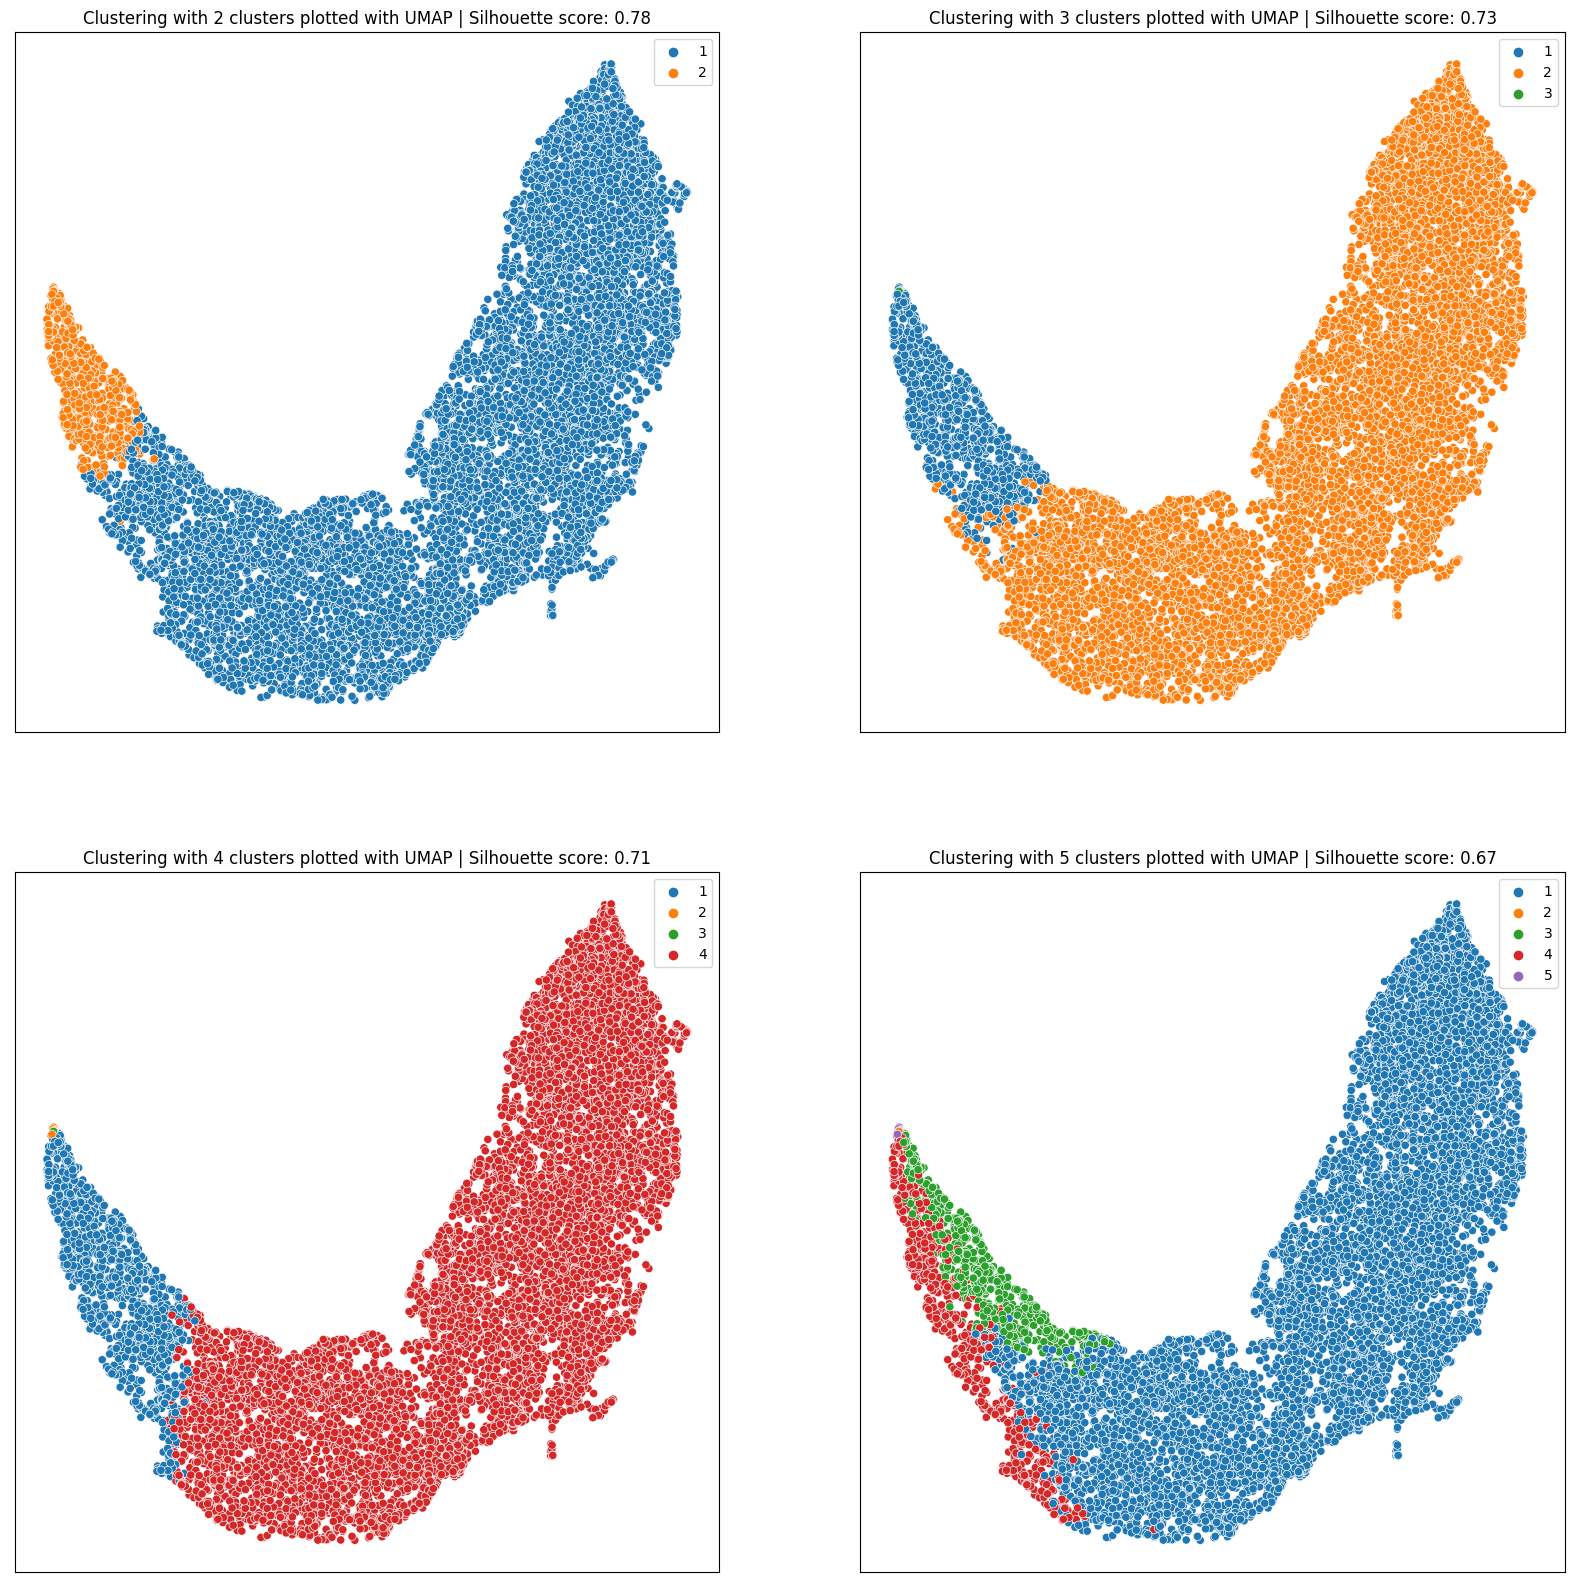

In [8]:
from umap import UMAP


embedding = UMAP().fit_transform(users_profiles)

# Plotting all the clustering using subplots and seaborn
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels[i]+1, ax=ax, palette='tab10')
    ax.set_title(f'Clustering with {i + 2} clusters plotted with UMAP | Silhouette score: {round(silhouette_scores[i], 2)}')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

Clusters seems very unbalanced, we can plot the number of users in each cluster to confirm this.

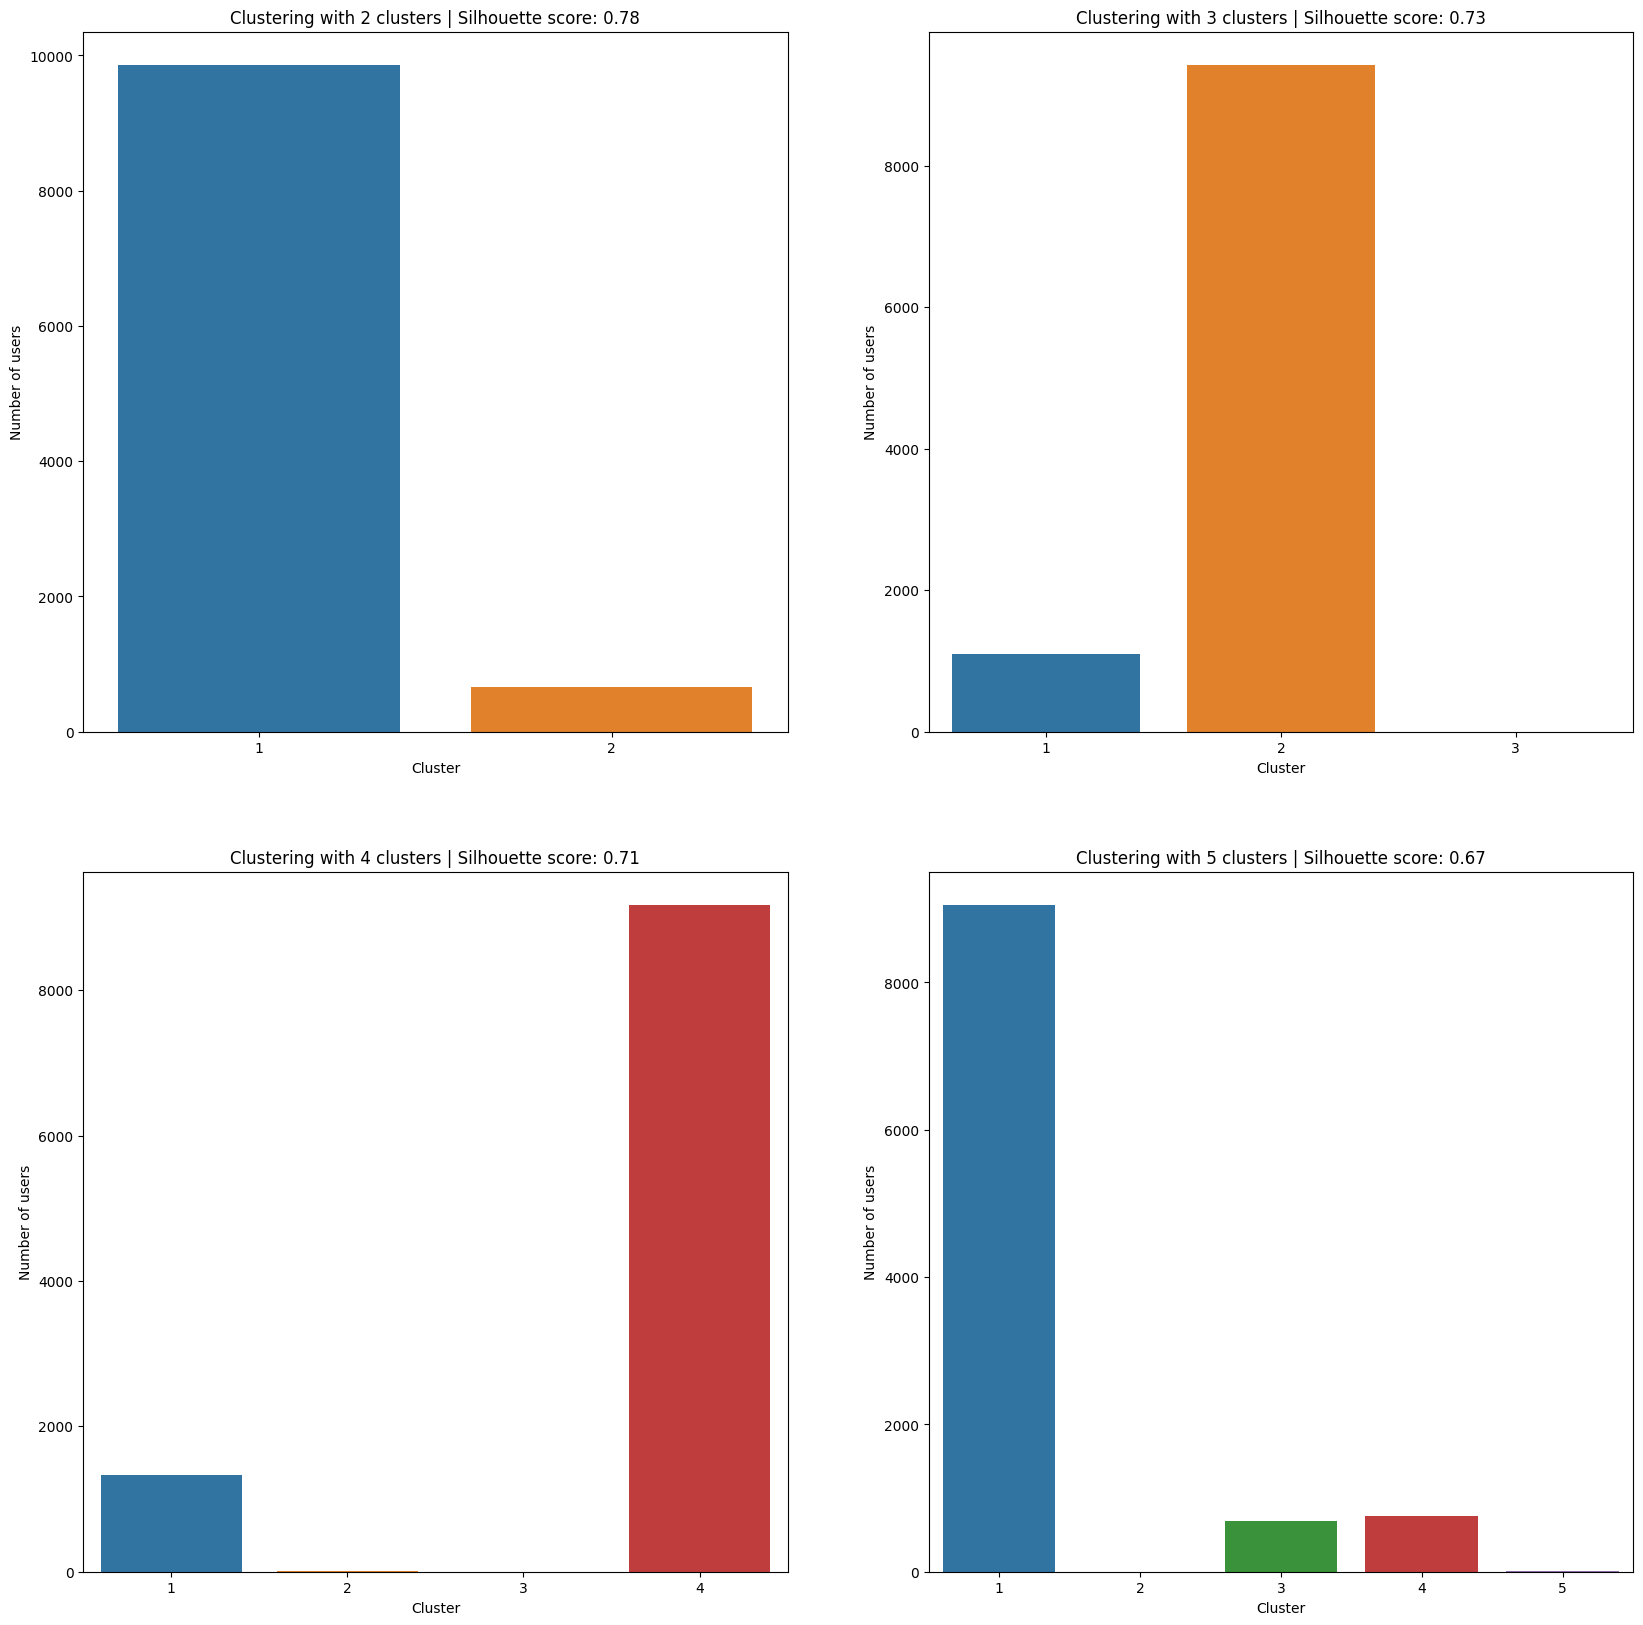

In [17]:
# Plotting the distribution between the clusters for each clsutering
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    sns.barplot(x=np.unique(labels[i], return_counts=True)[0]+1, y=np.unique(labels[i], return_counts=True)[1], ax=ax)
    ax.set_title(f'Clustering with {i + 2} clusters | Silhouette score: {round(silhouette_scores[i], 2)}')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Number of users')
plt.show()